<a href="https://colab.research.google.com/github/Oleksij-gh/PersonaFilmRecommender/blob/main/RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Global parameters

In [ ]:
seed = 42

# Data

## Donload and Unzip

In [ ]:
# Download data
!gdown 1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF

# Unzip data
import zipfile
with zipfile.ZipFile('/content/RecSys.zip') as zip:
    zip.extractall('/content/data')




Downloading...
From: https://drive.google.com/uc?id=1moqyaSdqD0VWfv-MKAcaCAO7W2RewAQF
To: /content/RecSys.zip
100% 9.92M/9.92M [00:00<00:00, 102MB/s]


## Visual analisys

In [ ]:
import pandas as pd

In [ ]:
person_data = pd.read_csv('/content/data/2018-personality-data.csv')
rating_data = pd.read_csv('/content/data/2018_ratings.csv')

In [ ]:
person_data = person_data.drop([' assigned metric',
       ' assigned condition', ' movie_1', ' predicted_rating_1', ' movie_2',
       ' predicted_rating_2', ' movie_3', ' predicted_rating_3', ' movie_4',
       ' predicted_rating_4', ' movie_5', ' predicted_rating_5', ' movie_6',
       ' predicted_rating_6', ' movie_7', ' predicted_rating_7', ' movie_8',
       ' predicted_rating_8', ' movie_9', ' predicted_rating_9', ' movie_10',
       ' predicted_rating_10', ' movie_11', ' predicted_rating_11',
       ' movie_12', ' predicted_rating_12', ' is_personalized',
       ' enjoy_watching '], axis=1)

In [ ]:
rating_data = rating_data.rename({'useri': 'userid'}, axis=1)

In [ ]:
rating_data.shape

(1028751, 4)

In [70]:
data = person_data.merge(rating_data, how="inner", on=['userid'])

In [ ]:
data.shape

(1070203, 9)

In [ ]:
person_data.head()

,userid,openness,agreeableness,emotional_stability,conscientiousness,extraversion
0,8e7cebf9a234c064b75016249f2ac65e,5.0,2.0,3.0,2.5,6.5
1,77c7d756a093150d4377720abeaeef76,7.0,4.0,6.0,5.5,4.0
2,b7e8a92987a530cc368719a0e60e26a3,4.0,3.0,4.5,2.0,2.5
3,92561f21446e017dd6b68b94b23ad5b7,5.5,5.5,4.0,4.5,4.0
4,030001ac2145a938b07e686a35a2d638,5.5,5.5,3.5,4.5,2.5


In [ ]:
rating_data.head()

,userid,movie_id,rating,tstamp
0,8e7cebf9a234c064b75016249f2ac65e,1,5.0,2001-09-10 17:19:56
1,8e7cebf9a234c064b75016249f2ac65e,2,4.0,2001-09-28 11:34:55
2,8e7cebf9a234c064b75016249f2ac65e,3,4.0,2001-09-28 11:42:50
3,8e7cebf9a234c064b75016249f2ac65e,5,5.0,2001-09-28 11:27:30
4,8e7cebf9a234c064b75016249f2ac65e,6,4.0,2002-01-07 18:12:02


In [74]:
data = data.drop(['userid', ' tstamp '], axis=1)
data.head()

,openness,agreeableness,emotional_stability,conscientiousness,extraversion,movie_id,rating
0,5.0,2.0,3.0,2.5,6.5,1,5.0
1,5.0,2.0,3.0,2.5,6.5,2,4.0
2,5.0,2.0,3.0,2.5,6.5,3,4.0
3,5.0,2.0,3.0,2.5,6.5,5,5.0
4,5.0,2.0,3.0,2.5,6.5,6,4.0


In [163]:
X = data.drop(' rating', axis = 1).values.astype('float32')
y = data[' rating'].values.astype('int')

# NN

## Split data

In [143]:
from sklearn.model_selection import train_test_split

def split_data(X, y, seed=42):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

  return X_train, y_train, X_val, y_val, X_test, y_test

## Pytorch

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import copy
import numpy as np

In [68]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [184]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

In [131]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x=torch.from_numpy(X)
        self.y=torch.from_numpy(y)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

Define train dataloader

In [185]:
train_data = Data(X_train, y_train)
train_dl = DataLoader(dataset=train_data, batch_size=64)

Define validate data

In [186]:
val_data = Data(X_train, y_train)
train_dl = DataLoader(dataset=train_data, batch_size=64)

Define test data

In [187]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = y_test


In [167]:
class Model(nn.Module):

    def __init__(self, input_shape, output_shape=6):
        super(Model, self).__init__()

        self.fc1 = nn.Linear(input_shape, 32)
        self.fc2 = nn.Linear(32, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_shape)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)


        return x

In [176]:
learning_rate = 0.1#1e-3

model = Model(X_train.shape[1], len(set(y)))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# training parameters
n_epochs = 6   # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_loss = np.inf   # init to infinity
best_weights = None
history = []
history_val = []

total_params = sum(p.numel() for p in model.parameters())
params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Trainable params count: {params_trainable }')
print(f'Total params count: {total_params}')

Trainable params count: 4614
Total params count: 4614


In [169]:
# training loop
for epoch in range(n_epochs):
    model.train()
    for X_train, y_train in tqdm(trainloader):

      # forward pass
      y_pred = model(X_train)

      # calculate loss
      loss = criterion(y_pred, y_train)

      # backward pass
      optimizer.zero_grad()
      loss.backward()

      # update weights
      optimizer.step()


    history.append(float(loss))

    # evaluate
    model.eval()
    with torch.no_grad():
        val_loss = criterion(loss_func, val_dl)


    # store best model
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

100%|██████████| 10034/10034 [00:29<00:00, 340.75it/s]


In [170]:
from matplotlib import pyplot as plt

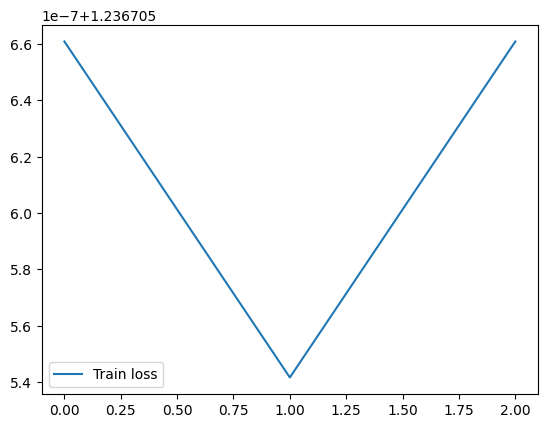

In [171]:
plt.plot(history)
plt.legend(['Train loss'])

plt.show()


In [181]:
y_pred = model(X_val)
y_pred = torch.max(y_pred.data, 1)
y_pred

torch.return_types.max(
values=tensor([  35.7224,   28.3150, 1089.5278,  ...,  176.4735,   45.1264,
         175.8054]),
indices=tensor([5, 5, 0,  ..., 1, 1, 1]))

In [155]:
print(y_val)

tensor([[4.],
        [3.],
        [2.],
        ...,
        [3.],
        [3.],
        [1.]])


In [ ]:
sklearn.model_selection.cross_val_score